In [ ]:
!pip install tensorflow==2.9.0
!pip install ampligraph

In [ ]:
import json
import numpy as np
from ampligraph.evaluation import train_test_split_no_unseen
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
from ampligraph.utils import save_model, restore_model
import tensorflow as tf


In [ ]:

def create_triples_from_winrate_data(winrate_with_data, agents_specializations):
    triples = []

    for i, data in enumerate(winrate_with_data):
        # Формируем идентификаторы для сущностей
        winrate_id = f"WinrateWithAgent{i}"
        agent_id = f"Agent{data['name'].capitalize()}"
        with_agent_id = f"Agent{data['withAgent'].capitalize()}"
        rank_id = f"Rank{data['rank']}"

        # Добавляем триплеты для winrate с другим агентом
        triples.append((winrate_id, "hasAgent", agent_id))
        triples.append((winrate_id, "withAgent", with_agent_id))
        triples.append((winrate_id, "hasRank", rank_id))
        triples.append((winrate_id, "winrateValue", data['winrate']))

    for agent, specialization in agents_specializations.items():
        agent_id = f"Agent{agent.capitalize()}"
        specialization_id = f"Specialization{specialization.capitalize()}"

        # Добавляем триплет для связи агента с его специализацией
        triples.append((agent_id, "hasSpecialization", specialization_id))

    return triples

# Загрузка данных из файла
file_path = "/content/drive/MyDrive/knowlege_graphs_project/winrate_with_data.json"
with open(file_path, 'r', encoding='utf-8') as f:
    winrate_with_data = json.load(f)

# Список агентов и их специализаций
agents_specializations = {
    "Gekko": "Initiator",
    "Fade": "Initiator",
    "Jett": "Duelist",
    "Phoenix": "Duelist",
    "Sage": "Sentinel",
    "Cypher": "Sentinel",
    "Omen": "Controller",
    "Brimstone": "Controller",
    "Viper": "Controller",
    "Killjoy": "Sentinel",
    "Sova": "Initiator",
    "Reyna": "Duelist",
    "Raze": "Duelist",
    "Astra": "Controller",
    "Harbor": "Controller",
    "Clove": "Controller",
    "Yoru": "Duelist",
    "Neon": "Duelist",
    "Iso": "Duelist",
    "Breach": "Initiator",
    "Sky": "Initiator",
    "KAY/O": "Initiator",
    "Chamber": "Sentinel",
    "Deadlock": "Sentinel",
    "Viper": "Sentinel",
}

# Генерация триплетов
triples = create_triples_from_winrate_data(winrate_with_data, agents_specializations)

In [ ]:
# Деление данных на обучающую и тестовую выборки
triples_array = np.array(triples)
X_train, X_valid = train_test_split_no_unseen(triples_array, test_size=10000)

# Ограничение размеров выборок
X_train = X_train[:300000]
X_valid = X_valid[:10000]

# Вывод размеров выборок
print('Train set size: ', X_train.shape)
print('Test set size: ', X_valid.shape)

Train set size:  (300000, 3)
Test set size:  (10000, 3)


In [ ]:
model = ScoringBasedEmbeddingModel(k=100,
                                   eta=20,
                                   scoring_type='ComplEx',
                                   seed=0)

# Определение оптимизатора, функции потерь и регуляризатора
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
loss = get_loss('multiclass_nll')
regularizer = get_regularizer('LP', {'p': 3, 'lambda': 1e-5})

# Компиляция модели
model.compile(optimizer=optimizer, loss=loss, entity_relation_regularizer=regularizer)

In [ ]:
# Обучение модели
model.fit(X_train,
          batch_size=int(X_train.shape[0] / 50),
          epochs=5,  # Количество эпох
          verbose=True)  # Отображение прогресса


Epoch 1/5
51/51 [==============================] - 112s 2s/step - loss: 24335.3535
Epoch 2/5
51/51 [==============================] - 104s 2s/step - loss: 23571.8125
Epoch 3/5
51/51 [==============================] - 102s 2s/step - loss: 22976.1426
Epoch 4/5
51/51 [==============================] - 109s 2s/step - loss: 22497.7754
Epoch 5/5
51/51 [==============================] - 101s 2s/step - loss: 22104.4199


In [ ]:

from ampligraph.utils import save_model, restore_model
model_save_path = '/content/drive/MyDrive/knowlege_graphs_project/trained_model'
save_model(model, model_save_path)


The path /content/drive/MyDrive/knowlege_graphs_project/trained_model already exists. This save operation will overwrite the model                 at the specified path.
WARNING - Found untraced functions such as _get_ranks while saving (showing 1 of 1). These functions will not be directly callable after loading.


In [ ]:
# Восстановление модели
model_save_path = '/content/drive/MyDrive/knowlege_graphs_project/trained_model'
restored_model = restore_model(model_save_path)
print("Model restored successfully!")

Saved model does not include a db file. Skipping.
Model restored successfully!


In [ ]:
ranks = restored_model.evaluate(X_valid,
                      use_filter={'train': X_train,
                                  'test': X_valid},
                      corrupt_side='s,o',
                      verbose=True)


1599 triples containing invalid keys skipped! You can use `ScoringBasedEmbeddingModel.get_invalid_keys` or`DataIndexer.get_invalid_keys` to find out which keys are invalid. 


1599 triples containing invalid keys skipped! You can use `ScoringBasedEmbeddingModel.get_invalid_keys` or`DataIndexer.get_invalid_keys` to find out which keys are invalid. 

842/842 [==============================] - 2323s 3s/step


In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.20
MR: 4043.26
Hits@10: 0.34
Hits@3: 0.11
Hits@1: 0.10


Кластеризация:

In [ ]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

Cloning into 'incf.countryutils'...
remote: Enumerating objects: 132, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 132 (delta 20), reused 39 (delta 16), pack-reused 87 (from 1)
Receiving objects: 100% (132/132), 66.24 KiB | 678.00 KiB/s, done.
Resolving deltas: 100% (58/58), done.
Processing /content/incf.countryutils
  Preparing metadata (setup.py) ... done
  Created wheel for incf.countryutils: filename=incf.countryutils-1.2-py3-none-any.whl size=21366 sha256=f3ee9edf58267ea91bbbd132c5f02e0bab1a3b11f7100a397f19e60433332c9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-yihdd3ta/wheels/c9/1a/60/d7400cda03816dbfc1647ccbb66be83b3e42077058131932d1
Successfully built incf.countryutils


In [ ]:
!pip install adjustText

22 22 22


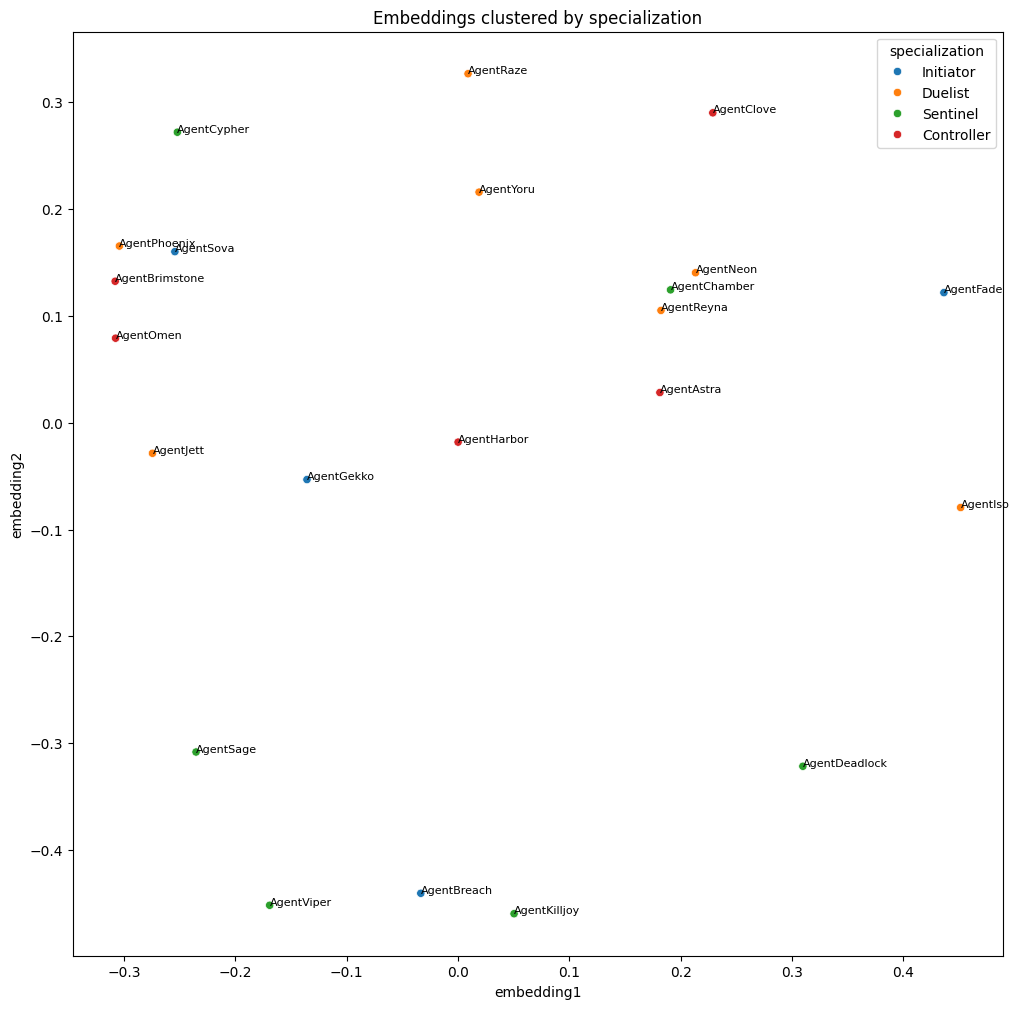

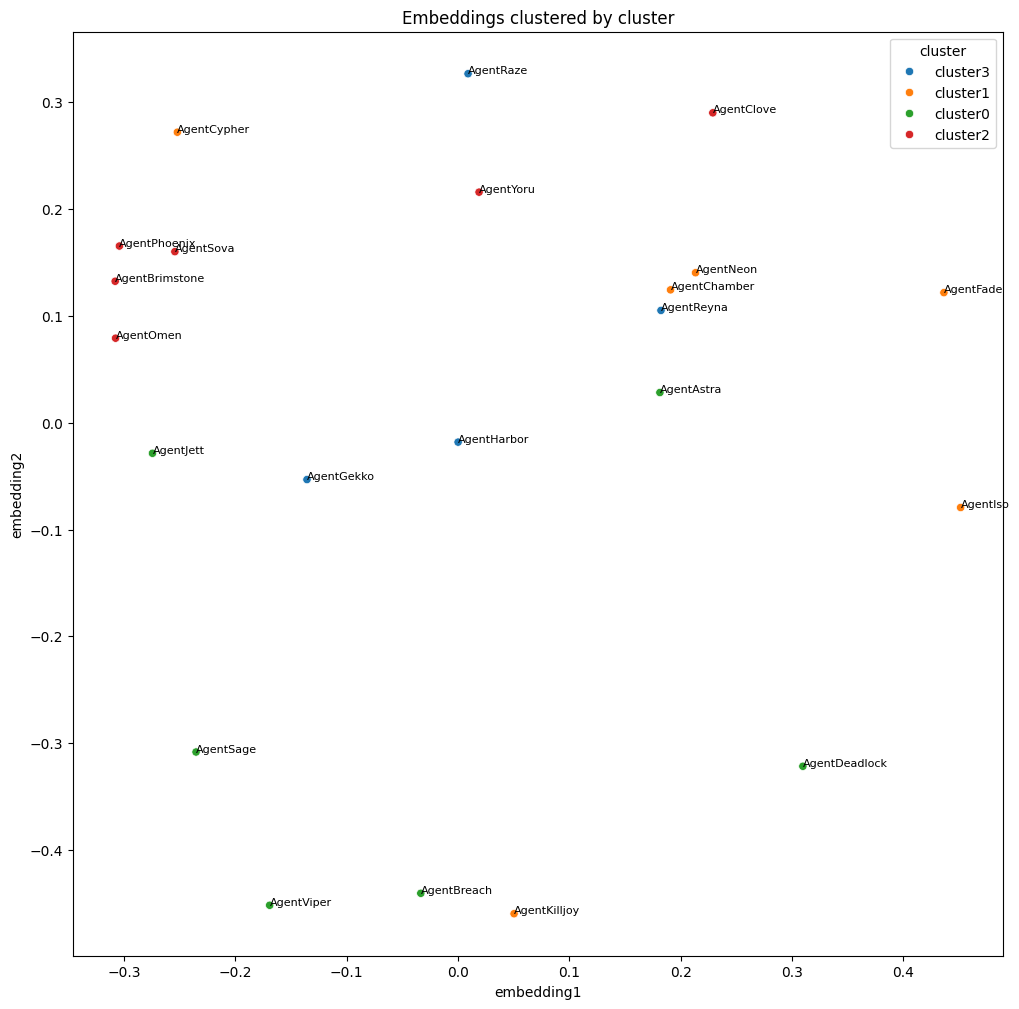

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from ampligraph.discovery import find_clusters
import matplotlib.pyplot as plt
import seaborn as sns

agents_specializations = {
    "Gekko": "Initiator",
    "Fade": "Initiator",
    "Jett": "Duelist",
    "Phoenix": "Duelist",
    "Sage": "Sentinel",
    "Cypher": "Sentinel",
    "Omen": "Controller",
    "Brimstone": "Controller",
    "Viper": "Controller",
    "Killjoy": "Sentinel",
    "Sova": "Initiator",
    "Reyna": "Duelist",
    "Raze": "Duelist",
    "Astra": "Controller",
    "Harbor": "Controller",
    "Clove": "Controller",
    "Yoru": "Duelist",
    "Neon": "Duelist",
    "Iso": "Duelist",
    "Breach": "Initiator",
    "Chamber": "Sentinel",
    "Deadlock": "Sentinel",
    "Viper": "Sentinel",
}
agents = [f"Agent{agent}" for agent in agents_specializations.keys()]

# Получение эмбеддингов агентов из восстановленной модели
agent_embeddings = dict(zip(agents, restored_model.get_embeddings(agents)))

# Снижение размерности эмбеддингов до 2D для визуализации
embeddings_2d = PCA(n_components=2).fit_transform(np.array(list(agent_embeddings.values())))
agents_array = np.array(agents)


# Кластеризация
clustering_algorithm = KMeans(n_clusters=4, n_init=50, max_iter=500, random_state=0)
clusters = find_clusters(agents_array, restored_model, clustering_algorithm, mode='e')
print( len(agents), embeddings_2d.shape[0],len(clusters))
# Создание DataFrame для визуализации
plot_df = pd.DataFrame({
    "agents": agents,
    "embedding1": embeddings_2d[:, 0],
    "embedding2": embeddings_2d[:, 1],
    "specialization": [agents_specializations[agent.split("Agent")[1]] for agent in agents],
    "cluster": "cluster" + pd.Series(clusters).astype(str)
})

# Визуализация кластеров
def plot_clusters(hue):
    plt.figure(figsize=(12, 12))
    plt.title(f"Embeddings clustered by {hue}".capitalize())
    sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue, palette="tab10")
    for _, point in plot_df.iterrows():
        plt.text(point['embedding1'], point['embedding2'], point["agents"], fontsize=8)
    plt.show()

# Визуализация кластеров по специализациям и результатам кластеризации
plot_clusters("specialization")
plot_clusters("cluster")

In [1]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.specialization, plot_df.cluster)

0.3298069122180756


Классификация:

In [ ]:
!pip install xgboost

In [ ]:
import numpy as np
import pandas as pd

file_path = "/content/drive/MyDrive/knowlege_graphs_project/winrate_with_data.json"
with open(file_path, 'r', encoding='utf-8') as f:
    winrate_with_data = json.load(f)
winrate_data = []
for data in winrate_with_data:
    winrate = data["winrate"]

    # Классификация винрейта
    if winrate < 50:
        classification = 0  # Менее 50%
    elif 45 <= winrate <= 55:
        classification = 1  # В районе 50%
    else:
        classification = 2  # Более 50%

    winrate_data.append({
        "agent": data["name"],
        "withAgent": data["withAgent"],
        "onRank": data['rank'],
        "classification": classification
    })


# Преобразуем в DataFrame
df = pd.DataFrame(winrate_data)

# Посмотрим на распределение классификаций
df["classification"].value_counts(normalize=True)

,proportion
classification,
0,0.500812
2,0.333430
1,0.165758


In [ ]:
# Пример функции для получения векторных представлений
def get_entity_vector(entity_id):
    # Здесь должен быть код для получения вектора из вашей модели
    return restored_model.get_embeddings([entity_id])[0]

# Добавляем векторы в DataFrame
df["agent_vector"] = df["agent"].apply(lambda x: get_entity_vector(f"Agent{x.capitalize()}"))
print("deone 1")
df["with_agent_vector"] = df["withAgent"].apply(lambda x: get_entity_vector(f"Agent{x.capitalize()}"))
print("deone 2")
df["rank_vector"] = df["onRank"].apply(lambda x: get_entity_vector(f"Rank{x}"))
print("deone 3")


deone 1
deone 2
deone 3


In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Объединяем все векторы в одну строку
def combine_vectors(row):
    return np.concatenate([row["agent_vector"], row["with_agent_vector"], row["rank_vector"]])

df["combined_vector"] = df.apply(combine_vectors, axis=1)

# Преобразуем векторы в DataFrame для модели
X = np.array(df["combined_vector"].tolist())
y = df["classification"]

# Разделяем данные на обучающую и тестовую выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
from xgboost import XGBClassifier

# Создаем модель
clf_model = XGBClassifier(n_estimators=10, max_depth=5, objective="multi:softmax")

# Обучаем модель на обучающей выборке
clf_model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
from sklearn import metrics

# Предсказание на тестовой выборке
y_pred = clf_model.predict(X_test)

# Оценка точности
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")


Accuracy: 0.63264292342


Link prediction

In [ ]:
import random
import pandas as pd
test_winrate_id = "WinrateWithAgent13"
test_agent_id = "AgentJett"
test_with_agent_id = "AgentOmen"
test_rank_id = "Rank20"
unique_winrates = list(set([triple[2] for triple in triples if triple[1] == "winrateValue"]))
random_winrates = random.sample(unique_winrates, min(5, len(unique_winrates)))
print(random_winrates)
test_statements = np.array([
    [test_winrate_id, "hasAgent", test_agent_id],
    [test_winrate_id, "withAgent", test_with_agent_id],
    [test_winrate_id, "hasRank", test_rank_id],
] + [[test_winrate_id, "winrateValue", value] for value in random_winrates])
invalid_keys = restored_model.get_invalid_keys(test_statements)
print("Invalid keys:", invalid_keys)
ranks = restored_model.evaluate(
    test_statements,
    use_filter=None,  # Фильтрация не используется
    corrupt_side='s,o',  # Подразумеваем генерацию негативных примеров по субъектам и объектам
    verbose=True
)
scores = restored_model.predict(test_statements)

# Конвертация оценок в вероятности (логистическая функция)
from scipy.special import expit
probs = expit(scores)
# Вывод результатов в DataFrame
print("Ranks shape:", np.shape(ranks))
print("Scores shape:", np.shape(scores))
print("Probs shape:", np.shape(probs))

# Создаем DataFrame с исправлением для одномерных данных
results_df = pd.DataFrame({
    'statement': [' '.join(x) for x in test_statements],
    'rank': ranks[:, 0],  # Используем первый столбец рангов
    'score': scores,  # Одномерный массив
    'prob': probs,  # Одномерный массив
}).sort_values("prob", ascending=False)

# Вывод результатов
print(results_df)


[36.17, 44.32, 57.45, 63.62, 47.19]
Invalid keys: ([], [], [])
2/2 [==============================] - 3s 2s/step
Ranks shape: (8, 2)
Scores shape: (8,)
Probs shape: (8,)
                               statement    rank     score       prob
7  WinrateWithAgent13 winrateValue 47.19   25287  0.001018  73.506380
5  WinrateWithAgent13 winrateValue 57.45  131431  0.000853  58.753647
3  WinrateWithAgent13 winrateValue 36.17  130630  0.000765  52.692991
6  WinrateWithAgent13 winrateValue 63.62  123205 -0.000397  46.255233
4  WinrateWithAgent13 winrateValue 44.32  132278 -0.000602  45.419288
